# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [ ]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [ ]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## Torus model

In [ ]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

ds = swyft.DataStoreZarr()
ds.init(zdim = zdim, xdim = x0.shape)

head = None

## Inference

In [ ]:
sw_list = []

In [5]:
for i_round, nsamples in enumerate([2000, 2000, 4000, 20000]):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = zdim, device = DEVICE, head = head, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = parent, threshold = 1e-4)
    sw_list.append(sw)

    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)

    sw.train1d(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Constrained posterior area: 1.0
Adding 2058 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 5
Validation losses: [5.243196725845337, 4.649480372667313, 4.171160578727722, 4.059040084481239, 4.206350594758987]
LR iteration 1
Total epochs: 3
Validation losses: [4.022410675883293, 3.9834299087524414, 4.055077508091927]
LR iteration 2
Total epochs: 2
Validation losses: [3.9343666285276413, 4.067330315709114]
Constrained posterior area: 0.13143761
Adding 1766 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 5
Validation losses: [6.6253504157066345, 6.337149918079376, 6.110634803771973, 6.055589884519577, 6.095669507980347]
LR iteration 1
Total epochs: 3
Validation losses: [5.86269947886467, 5.847358137369156, 5.913616597652435]
LR iteration 2
Total epochs: 4
Validation losses: [5.938360571861267, 5.899804919958115, 5.777797698974609, 5.858050495386124]
Constrained posterior area: 0.07115065
Adding 2838 new samples. Run simulator!
Start training

In [6]:
print("Total number of samples in datastore:", len(ds))

Total number of samples in datastore: 25068


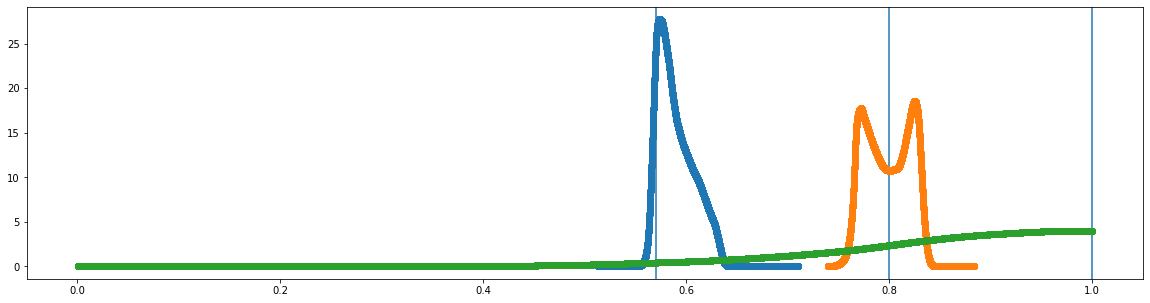

In [7]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p, marker='o')

In [8]:
sw_list[-1].trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4], tag = 'default')

Start training
LR iteration 0
Total epochs: 5
Validation losses: [4.972765609622002, 4.5245722979307175, 4.514515578746796, 4.367416143417358, 4.446009874343872]
LR iteration 1
Total epochs: 4
Validation losses: [4.6187038868665695, 4.467118546366692, 4.093846693634987, 4.294892519712448]
LR iteration 2
Total epochs: 4
Validation losses: [4.372926786541939, 4.285497769713402, 4.166142016649246, 4.195731803774834]


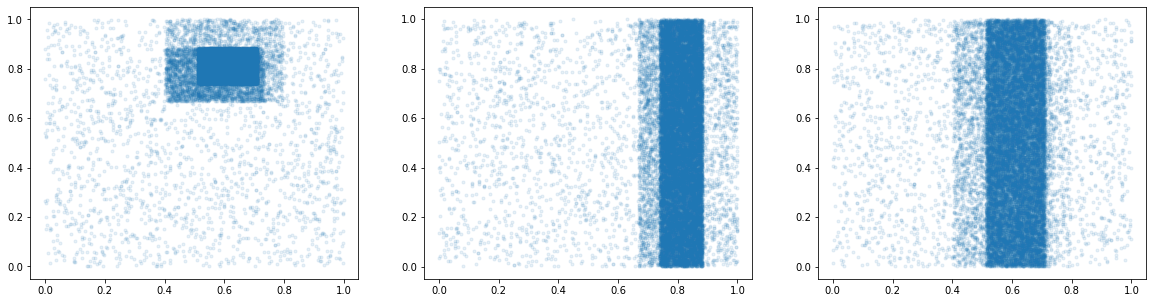

In [11]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(ds.z[:,0], ds.z[:,1], marker='.', alpha = 0.1)
plt.subplot(132)
plt.scatter(ds.z[:,1], ds.z[:,2], marker='.', alpha = 0.1)
plt.subplot(133)
plt.scatter(ds.z[:,0], ds.z[:,2], marker='.', alpha = 0.1)

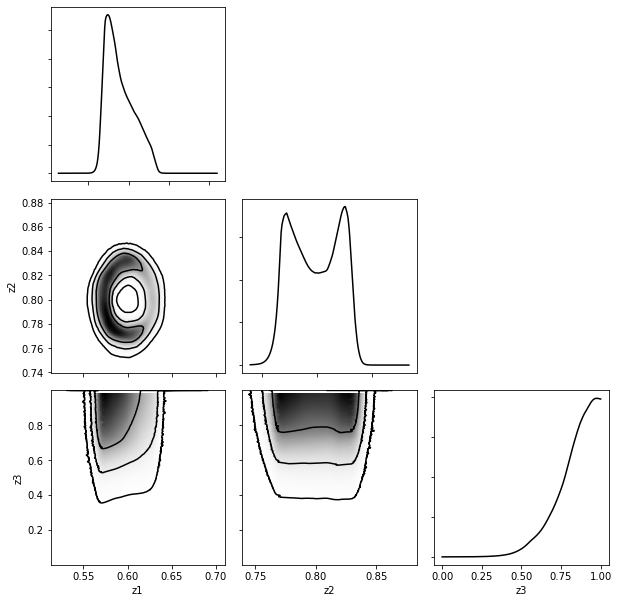

In [12]:
swyft.corner(sw_list[-1], tag = 'default')
#plt.savefig("corner.pdf")